# Italian Power Loads: Time Series Forecasting (1)

This notebook is used to tackle Challenge 1 of the 'Italian Power Load' exercise shared by [xtream](https://xtreamers.io/) team as part of the [xtream AI Challenge](https://github.com/xtreamsrl/xtream-ai-assignment). The aim of Challenge 1 is to provide a report on main features of a power load series, that runs from 2006 to 2022. The next step is then to dive into Challenge 2, whose goal is to develop a forecasting model for the power load that has a forecasting horizon of one year ahead.

Main building blocks for the following codes are based on the blog post [Forecasting energy demand with machine learning](https://cienciadedatos.net/documentos/py29-forecasting-electricity-power-demand-python.html), last accessed December 2023, which was used as main reference.

## Libraries

The libraries used in this notebook are:

In [1]:
# Data manipulation
# ==============================================================================
import numpy as np
import pandas as pd

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.io as pio
import plotly.offline as poff
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


pio.renderers.default = 'notebook' 
pio.templates.default = "seaborn"
poff.init_notebook_mode(connected=True)
plt.style.use('seaborn-v0_8-darkgrid')

## Data

A time series of the Italian power load (Wh) for a fictional power player is provided, covering a timespan from 2006-01-01 to 2022-02-07. The dataset can be found in the [italian-power-load](https://github.com/xtreamsrl/xtream-ai-assignment/tree/main/datasets/italian-power-load) folder. The set contains 2 columns and 5882 records, each column encoding the date of the record and the power load (Wh).

In [2]:
# Loading the data
# ==============================================================================
data = pd.read_csv('datasets/italian-power-load/load.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5882 entries, 0 to 5881
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    5882 non-null   object 
 1   Load    5882 non-null   float64
dtypes: float64(1), object(1)
memory usage: 92.0+ KB


Now one manipulates the data, converting the `Date` column to `datetime` format, and setting it as index. The frequeuency `1D` is specified as the data have been taken every 1 day. 

In [3]:
# Data preparation
# ==============================================================================
data['Date'] = pd.to_datetime(data['Date'], format='%Y-%m-%d')
data = data.set_index('Date')
data = data.asfreq('1D')
data = data.sort_index()
data.head(2) 

,Load
Date,
2006-01-01,666542.0
2006-01-02,855403.0


Missing data are checked with frequency of 1 day, and if any, a not-a-number (`nan`) value is used for filling them. In this case, the time series is complete.

In [4]:
# Verify that the time series is complete
# ==============================================================================
(data.index == pd.date_range(start=data.index.min(),
                             end=data.index.max(),
                             freq=data.index.freq)).all()

print(f"Number of rows with missing values: {data.isnull().any(axis=1).mean()}")

# if not complete, fill with NaN values
if data.isnull().any(axis=1).mean() > 0.0:
    data.asfreq(freq='1D', fill_value=np.nan)

Number of rows with missing values: 0.0


Since the ultimate aim is to provide a time series forecasting, the data is divided into 3 sets: training, validation and test. As suggested by our colleague Marta, year 2020 is a very particular year, thus, in this case, the span 2020-2022 are not taken into account, and saved in a `dataNotUsed` variable for plotting purposes only. The testing of the forecasting model is performed with 2019 as a reference.

In [5]:
# Extract the 2020-2022 data
# ==============================================================================
dataNotUsed = data.loc['2020-01-01':].copy()

# Split the remaining data into train-validation-test
# ==============================================================================
data = data.loc['2006-01-01': '2019-12-31'].copy()
start_train = '2006-01-01'
end_train = '2017-12-31'
start_validation = '2018-01-01'
end_validation = '2018-12-31'
start_test = '2019-01-01'
data_train = data.loc[start_train:end_train, :].copy()
data_val   = data.loc[start_validation:end_validation, :].copy()
data_test  = data.loc[start_test:, :].copy()

print(f"Train dates      : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Validation dates : {data_val.index.min()} --- {data_val.index.max()}  (n={len(data_val)})")
print(f"Test dates       : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

Train dates      : 2006-01-01 00:00:00 --- 2017-12-31 00:00:00  (n=4383)
Validation dates : 2018-01-01 00:00:00 --- 2018-12-31 00:00:00  (n=365)
Test dates       : 2019-01-01 00:00:00 --- 2019-12-31 00:00:00  (n=365)


## Graphs

In this section, graphical exploration is provided of the dataset. This allows to identify trends and patterns. The section first provides plots the full time series, providing some zoom on interesting areas, and then presents some seasonality plots.

### Plot time series

To plot the time series, a `go.Figure()` object is created using the Plotly libray, that provides interactive plots by default. Train, validation and test data are provided.

In [10]:
# Interactive plot of time series
# ==============================================================================
fig = go.Figure()
fig.add_trace(go.Scatter(x=data.index, y=data['Load'], mode='lines', name='Load'))
fig.update_layout(
    title  = 'Power load (Wh)',
    xaxis_title="Time",
    yaxis_title="Load",
    legend_title="Partition:",
    width=850,
    height=400,
    margin=dict(l=20, r=20, t=35, b=20),
    legend=dict(
        orientation="h",
        yanchor="top",
        y=1,
        xanchor="left",
        x=0.001
    )
)
fig.show()

In [21]:
# Interactive plot of time series
# ==============================================================================
fig = go.Figure()
fig.add_trace(go.Scatter(x=data_train.index, y=data_train['Load'], mode='lines', name='Train'))
fig.add_trace(go.Scatter(x=data_val.index, y=data_val['Load'], mode='lines', name='Validation'))
fig.add_trace(go.Scatter(x=data_test.index, y=data_test['Load'], mode='lines', name='Test'))
fig.update_layout(
    title  = 'Power load (Wh)',
    xaxis_title="Time",
    yaxis_title="Load",
    legend_title="Partition:",
    width=850,
    height=400,
    margin=dict(l=20, r=20, t=35, b=20),
    legend=dict(
        orientation="h",
        yanchor="top",
        y=1,
        xanchor="left",
        x=0.001
    )
)
fig.show()

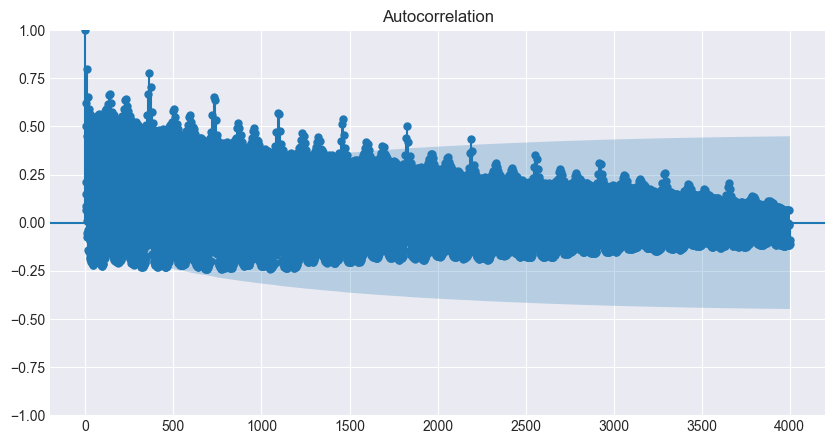

In [52]:
# Autocorrelation plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(10, 5))
plot_acf(data.Load, ax=ax, lags=4000)
plt.show()

From the graph one notices that the power load has annual seasonality. In particular, highest peaks occurr almost every July, while lowest peaks are shifted approximately 4 months one after the other (e.g., December/January to April, April to August, August to December/January). This is also shown in the following figure, zooming on a reference year (2018 in this case).

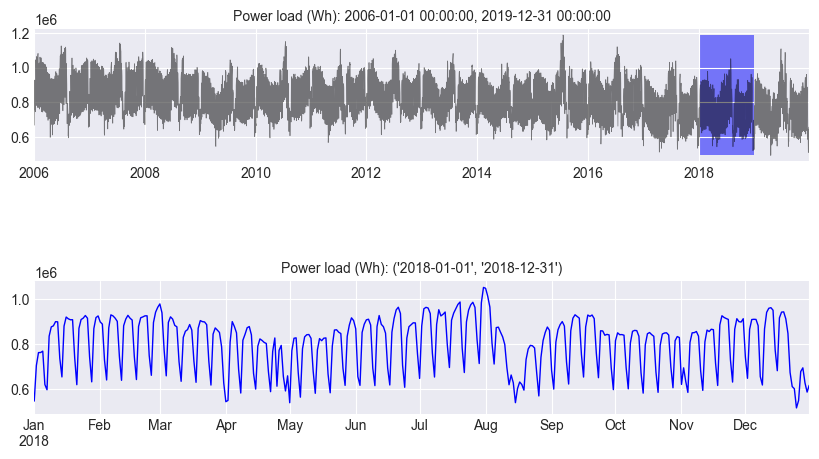

In [22]:
# Zooming time series chart
# ==============================================================================
zoom = ('2018-01-01','2018-12-31')

fig = plt.figure(figsize=(10, 5))
grid = plt.GridSpec(nrows=8, ncols=1, hspace=0.6, wspace=0)

main_ax = fig.add_subplot(grid[:3, :])
data.Load.plot(ax=main_ax, c='black', alpha=0.5, linewidth=0.5)
min_y = min(data.Load)
max_y = max(data.Load)
main_ax.fill_between(zoom, min_y, max_y, facecolor='blue', alpha=0.5, zorder=0)
main_ax.set_title(f'Power load (Wh): {data.index.min()}, {data.index.max()}', fontsize=10)
main_ax.set_xlabel('')

zoom_ax = fig.add_subplot(grid[5:, :])
data.loc[zoom[0]: zoom[1]].Load.plot(ax=zoom_ax, color='blue', linewidth=1)
zoom_ax.set_title(f'Power load (Wh): {zoom}', fontsize=10)
zoom_ax.set_xlabel('')

plt.subplots_adjust(hspace=1)
plt.show()

A zoom is also provided on a reference short-term period (i.e., January-February span in 2018, in this case). This shows that the power load is cyclic with respect to the day of the week. In particular, since the 2018-01-01 was Sunday, the power load reaches its minimum roughly every 7 days, i.e., every weekend.

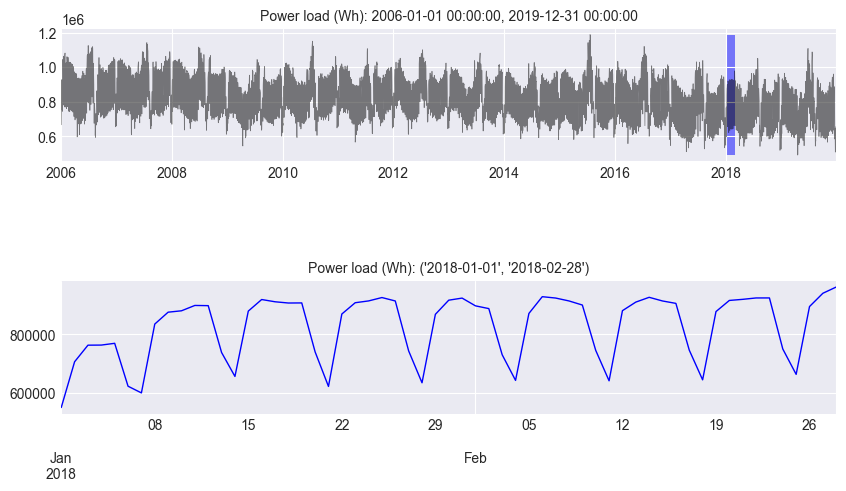

In [23]:
# Zooming time series chart
# ==============================================================================
zoom = ('2018-01-01','2018-02-28')

fig = plt.figure(figsize=(10, 5))
grid = plt.GridSpec(nrows=8, ncols=1, hspace=0.6, wspace=0)

main_ax = fig.add_subplot(grid[:3, :])
data.Load.plot(ax=main_ax, c='black', alpha=0.5, linewidth=0.5)
min_y = min(data.Load)
max_y = max(data.Load)
main_ax.fill_between(zoom, min_y, max_y, facecolor='blue', alpha=0.5, zorder=0)
main_ax.set_title(f'Power load (Wh): {data.index.min()}, {data.index.max()}', fontsize=10)
main_ax.set_xlabel('')

zoom_ax = fig.add_subplot(grid[5:, :])
data.loc[zoom[0]: zoom[1]].Load.plot(ax=zoom_ax, color='blue', linewidth=1)
zoom_ax.set_title(f'Power load (Wh): {zoom}', fontsize=10)
zoom_ax.set_xlabel('')

plt.subplots_adjust(hspace=1)
plt.show()

The year 2020 is now zoomed in.

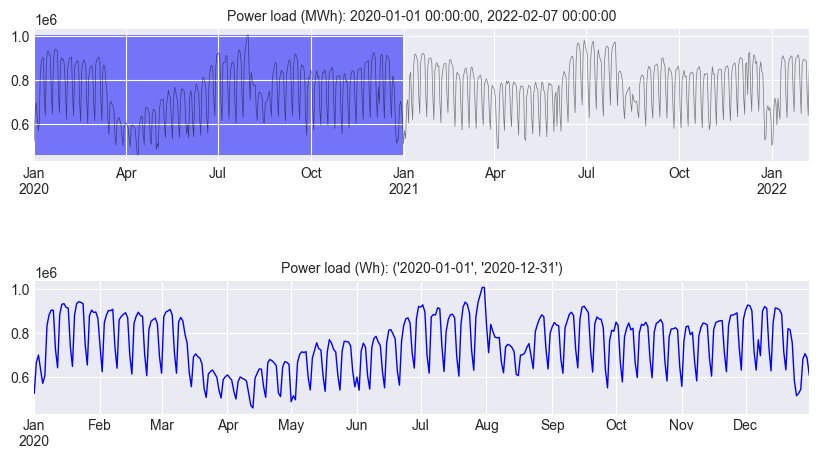

In [24]:
# Zooming time series chart on the not used data
# ==============================================================================
zoom = ('2020-01-01','2020-12-31')

fig = plt.figure(figsize=(10, 5))
grid = plt.GridSpec(nrows=8, ncols=1, hspace=0.6, wspace=0)

main_ax = fig.add_subplot(grid[:3, :])
dataNotUsed.Load.plot(ax=main_ax, c='black', alpha=0.5, linewidth=0.5)
min_y = min(dataNotUsed.Load)
max_y = max(dataNotUsed.Load)
main_ax.fill_between(zoom, min_y, max_y, facecolor='blue', alpha=0.5, zorder=0)
main_ax.set_title(f'Power load (MWh): {dataNotUsed.index.min()}, {dataNotUsed.index.max()}', fontsize=10)
main_ax.set_xlabel('')

zoom_ax = fig.add_subplot(grid[5:, :])
dataNotUsed.loc[zoom[0]: zoom[1]].Load.plot(ax=zoom_ax, color='blue', linewidth=1)
zoom_ax.set_title(f'Power load (Wh): {zoom}', fontsize=10)
zoom_ax.set_xlabel('')

plt.subplots_adjust(hspace=1)
plt.show()

Compared to other years, a drop in the power load is registered in 2020 starting in March and reaching a minimum in April. This is likely due to COVID-19 pandemic restrictions.

### Seasonality plots

Seasonal plots are provided to identify seasonal patterns and trends in the series. This can be obtained with boxplots, that average the data over time.

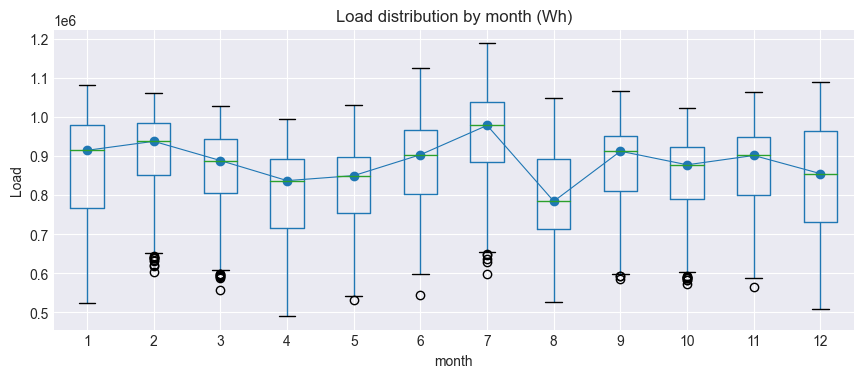

In [25]:
# Load distribution by month
# ==============================================================================
fig, ax = plt.subplots(figsize=(10, 4))
data['month'] = data.index.month
data.boxplot(column='Load', by='month', ax=ax,)
data.groupby('month')['Load'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('Load')
ax.set_title('Load distribution by month (Wh)')
fig.suptitle('')
plt.show()

It is observed an annual peak in July, with minimum in August, possibly due to the summer period closure.

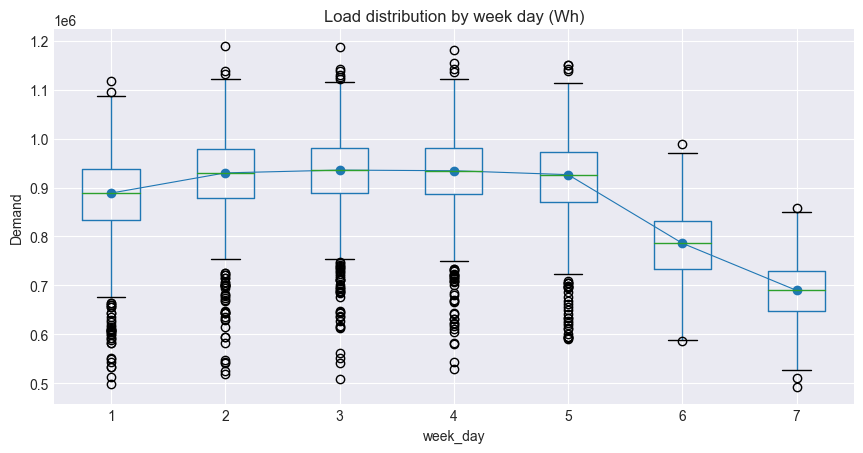

In [26]:
# Demand distribution by week day
# ==============================================================================
fig, ax = plt.subplots(figsize=(10, 5))
data['week_day'] = data.index.day_of_week + 1
data.boxplot(column='Load', by='week_day', ax=ax)
data.groupby('week_day')['Load'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('Demand')
ax.set_title('Load distribution by week day (Wh)')
fig.suptitle('')
plt.show()

The load increases in the mid-days of the week, with minimum in the weekends.